In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


Enter the coin names separated by commas (e.g., bitcoin, ethereum, litecoin): bitcoin, litecoin, ripple, solana
Enter the number of days for historical data (e.g., 365 for one year): 365
Analyzing bitcoin...
Analyzing litecoin...
Analyzing ripple...
Analyzing solana...


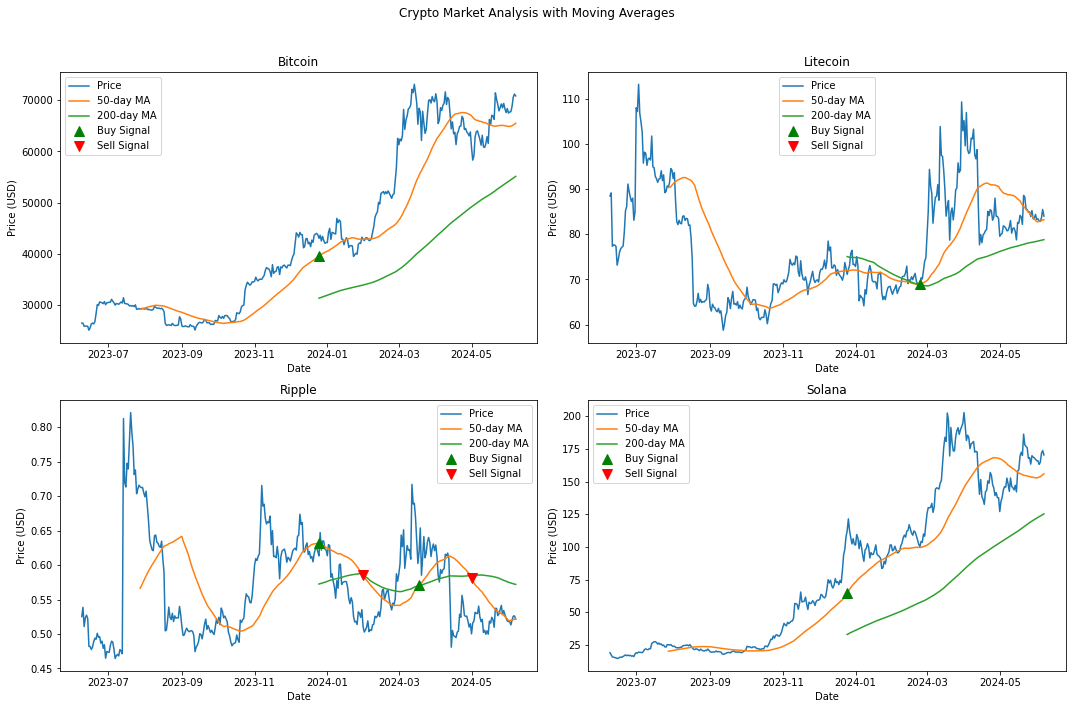

In [6]:
import warnings
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
warnings.filterwarnings('ignore')

API_URL = "https://api.coingecko.com/api/v3"

def fetch_historical_data(coin, vs_currency="usd", days="365", interval="daily"):
    try:
        endpoint = f"/coins/{coin}/market_chart"
        params = {
            "vs_currency": vs_currency,
            "days": days,
            "interval": interval
        }
        response = requests.get(API_URL + endpoint, params=params)
        response.raise_for_status()
        data = response.json()
        prices = data["prices"]
        return prices
    except Exception as e:
        print(f"Error fetching data for {coin}: {e}")
        return None

def process_data(prices):
    df = pd.DataFrame(prices, columns=["timestamp", "price"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
    df.set_index("timestamp", inplace=True)

    df["50_MA"] = df["price"].rolling(window=50).mean()
    df["200_MA"] = df["price"].rolling(window=200).mean()

    return df

def generate_signals(df):
    df["signal"] = 0
    df["signal"][50:] = np.where(df["50_MA"][50:] > df["200_MA"][50:], 1, 0)
    df["position"] = df["signal"].diff()

    return df

def plot_data(dfs, coins):
    num_coins = len(coins)
    num_pages = (num_coins + 3) // 4

    for page in range(num_pages):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Crypto Market Analysis with Moving Averages")

        for i in range(4):
            idx = page * 4 + i
            if idx < num_coins:
                ax = axs[i // 2, i % 2]
                df = dfs[idx]
                coin = coins[idx]

                ax.plot(df["price"], label="Price")
                ax.plot(df["50_MA"], label="50-day MA")
                ax.plot(df["200_MA"], label="200-day MA")

                ax.plot(df[df["position"] == 1].index,
                        df["50_MA"][df["position"] == 1],
                        "^", markersize=10, color="g", lw=0, label="Buy Signal")

                ax.plot(df[df["position"] == -1].index,
                        df["50_MA"][df["position"] == -1],
                        "v", markersize=10, color="r", lw=0, label="Sell Signal")

                ax.set_title(f"{coin.capitalize()}")
                ax.set_xlabel("Date")
                ax.set_ylabel("Price (USD)")
                ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

def analyze_coins(coins, days):
    dfs = []
    for coin in coins:
        print(f"Analyzing {coin}...")
        historical_data = fetch_historical_data(coin, days=days)
        if historical_data:
            df = process_data(historical_data)
            df = generate_signals(df)
            dfs.append(df)
        else:
            print(f"Skipping {coin} due to data fetch error.")
    plot_data(dfs, coins)

def get_user_input():
    if 'DISPLAY' in os.environ:
        try:
            import tkinter as tk
            from tkinter import simpledialog

            root = tk.Tk()
            root.withdraw()

            coins_input = simpledialog.askstring("Input", "Enter the coin names separated by commas (e.g., bitcoin, ethereum, litecoin):")
            date_input = simpledialog.askstring("Input", "Enter the number of days for historical data (e.g., 365 for one year):")

            if coins_input and date_input:
                coins = [coin.strip() for coin in coins_input.split(",")]
                try:
                    days = int(date_input)
                except ValueError:
                    days = 365  
                return coins, days
            else:
                return None, None
        except ImportError:
            pass

    coins_input = input("Enter the coin names separated by commas (e.g., bitcoin, ethereum, litecoin): ")
    date_input = input("Enter the number of days for historical data (e.g., 365 for one year): ")

    if coins_input and date_input:
        coins = [coin.strip() for coin in coins_input.split(",")]
        try:
            days = int(date_input)
        except ValueError:
            days = 365  
        return coins, days
    else:
        return None, None

if __name__ == "__main__":
    coins, days = get_user_input()
    if coins and days:
        analyze_coins(coins, days)
    else:
        print("Invalid input. Please try again.")
